In [1]:
!pip install scikit-multilearn
import nltk
nltk.download('stopwords')
nltk.download('punkt')

     |████████████████████████████████| 92kB 3.1MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
import os
from google.colab import drive
 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/My Drive/Kaggle'

/content/gdrive/My Drive/Kaggle


In [4]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,classification_report,hamming_loss

In [5]:
#Taking only 100000 points due to computational cost
data= pd.read_csv('Train.csv',nrows=100000)

In [6]:
data.head(5)

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [7]:
import sqlite3 
#Making a connection to database
conn = sqlite3.connect('Tag.db') 
c = conn.cursor()
#Creating tables
c.execute('CREATE TABLE Tag (Id, Title, Body, Tags )')
conn.commit()

In [8]:
#Appending dataframe to database
data.to_sql('Tag', conn, if_exists='replace', index = False)

In [9]:
#Printing the 1st 10 rows
c.execute('''  
SELECT * FROM Tag LIMIT 10
          ''')
for row in c.fetchall():
    print(row)

(1, 'How to check if an uploaded file is an image without mime type?', "<p>I'd like to check if an uploaded file is an image file (e.g png, jpg, jpeg, gif, bmp) or another file. The problem is that I'm using Uploadify to upload the files, which changes the mime type and gives a 'text/octal' or something as the mime type, no matter which file type you upload.</p>\n\n<p>Is there a way to check if the uploaded file is an image apart from checking the file extension using PHP?</p>\n", 'php image-processing file-upload upload mime-types')
(2, 'How can I prevent firefox from closing when I press ctrl-w', '<p>In my favorite editor (vim), I regularly use ctrl-w to execute a certain action. Now, it quite often happens to me that firefox is the active window (on windows) while I still look at vim (thinking vim is the active window) and press ctrl-w which closes firefox. This is not what I want. Is there a way to stop ctrl-w from closing firefox?</p>\n\n<p>Rene</p>\n', 'firefox')
(3, 'R Error Inv

In [10]:
#Counting the duplicate tags using groupby
con = sqlite3.connect('Tag.db')
data1 = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as duplicate_counts FROM Tag GROUP BY Title, Body, Tags', con)
con.close()

In [11]:
data1.head(5)

,Title,Body,Tags,duplicate_counts
0,Accessing @Local Session Bean from an exposed...,<p>What I am trying to do should be very strai...,ejb resteasy,1
1,Encoding of sent data not working,"<p>I've got a little chatbox, everything's wor...",php jquery ajax encoding,1
2,"Files in Array, in Array to Tree?","<p>Using <code>C#</code>, I have created a pro...",c# visual-studio-2010 visual-studio-2008 clear...,1
3,Google Map location based on address,"<p>Im using Google Map in my application, it i...",android google-maps,1
4,How to insert custom field in typo3 Dam modul...,<p>I introduced my custom field in Dam modules...,typo3 dam,1


In [12]:
#Finding the rows which had duplicates
data1[data1['duplicate_counts'] > 1]

,Title,Body,Tags,duplicate_counts
30,"""Allow this device to wake up the computer"" di...",<p>I have a wireless network adapter which I w...,windows-7 wake-on-lan,2
55,"""Closures are poor man's objects and vice vers...",<blockquote>\n <p>Closures are poor man's obj...,functional-programming object oop closures,2
263,# ifdef type conditional compilation in T-SQL ...,<p>For sake of backwards compatibility I need ...,sql-server sql-server-2005 tsql sql-server-2008,2
536,.NET Framework 4.0 installation is very slow,"<p>On my Windows Vista, it takes a full <b>12 ...",.net-framework installer installation,2
616,.Net application deployment under Terminal Ser...,<p>I just wanted to see if its possible or eve...,terminal-server .net terminal-services softwar...,2
...,...,...,...,...
98719,what is the difference between >> and >>> oper...,<p>Running the following JavaScript code shows...,javascript bitwise-operators,2
98764,what is this strange behavior when I click in ...,<p>I'm using Excel 2010 and I'm trying to edit...,microsoft-excel-2010,2
99100,windows 7 adhoc annoyance,<p>When i get disconnected from my wifi someho...,windows-7 wireless-networking internet-connect...,2
99117,windows scroll using javascript in fluid layou...,"<p>Hey guys <a href=""http://www.girisoft.net/l...",javascript html css,2


In [13]:
print(data.shape)
print(data1.shape)
print(data.shape[0] - data1.shape[0])
per = round(((data.shape[0] - data1.shape[0])/data.shape[0])*100,2)
print(f"Percentage of duplicate questions = {per}%")

(100000, 4)
(99436, 4)
564
Percentage of duplicate questions = 0.56%


In [14]:
# number of times each question appeared in our dataset
data1['duplicate_counts'].value_counts()

1    98874
2      560
3        2
Name: duplicate_counts, dtype: int64

In [15]:
#Finding the length of tags per question and appending it into Tag_Count
tag_length  = data['Tags'].apply(lambda x : str(x). split())
length = [len(i) for i in tag_length]
data['Tag_Length'] = length

In [16]:
data['Tag_Length']

0        5
1        1
2        3
3        3
4        3
        ..
99995    2
99996    4
99997    2
99998    3
99999    3
Name: Tag_Length, Length: 100000, dtype: int64

In [17]:
#percantage of number of tags present in each question
data['Tag_Length'].value_counts(normalize=True)

3    0.28769
2    0.26540
4    0.19108
1    0.13858
5    0.11725
Name: Tag_Length, dtype: float64

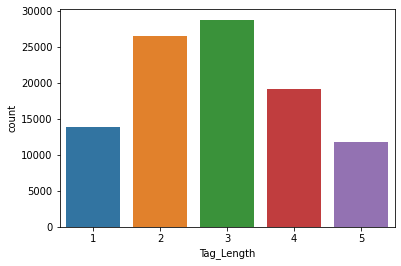

In [18]:
#Number of Tags in question
sns.countplot(data['Tag_Length'])

#Tag Analysis

In [19]:
cv = CountVectorizer(tokenizer = lambda x: str(x).split())
per_tag_count= cv.fit_transform(data1['Tags'])

In [20]:
print(f'Total number of tags = {data1.shape[0]} ')
print(f'Number of unique tags = {per_tag_count.shape[1]}')

Total number of tags = 99436 
Number of unique tags = 18448


In [21]:
#Finding the count of each tag by adding the rows 
count = per_tag_count.sum(axis=0).A1
#Getting the names of Tags
tag_names = cv.get_feature_names()
#Adding it to a dictionary
per_tag_count_data = dict(zip(tag_names, count))

In [22]:
per_tag_count_data

{'.a': 2,
 '.bash-profile': 1,
 '.class-file': 1,
 '.each': 6,
 '.emf': 2,
 '.hgtags': 2,
 '.htaccess': 331,
 '.htpasswd': 1,
 '.mov': 1,
 '.net': 2668,
 '.net-1.1': 3,
 '.net-2.0': 31,
 '.net-3.5': 84,
 '.net-4.0': 125,
 '.net-4.5': 17,
 '.net-assembly': 22,
 '.net-cf-3.5': 1,
 '.net-framework': 5,
 '.net-install': 1,
 '.net-micro-framework': 2,
 '.net-remoting': 4,
 '.net-security': 1,
 '.net2.0': 1,
 '.net3.5': 1,
 '.net4.0': 2,
 '.nettiers': 2,
 '.obj': 1,
 '.post': 4,
 '.rdlc': 1,
 '.refresh': 1,
 '.sdf': 1,
 '.war': 1,
 '.wav': 1,
 '.x': 2,
 '1080p': 2,
 '10gbethernet': 2,
 '10gige': 1,
 '16bit': 2,
 '1and1': 2,
 '2-legged': 1,
 '2-tier': 1,
 '2003': 2,
 '2007': 71,
 '2010': 106,
 '2013': 13,
 '24bit': 1,
 '24hour': 1,
 '2d': 35,
 '2d-array': 9,
 '2d-games': 1,
 '2wire': 2,
 '3-tier': 3,
 '3.0': 14,
 '3.0.1': 1,
 '3.1': 1,
 '301': 2,
 '301-redirect': 1,
 '32-bit': 13,
 '32-vs-64-bit': 1,
 '3270': 1,
 '32bit': 5,
 '32bit-64bit': 17,
 '37-signals': 1,
 '3750': 1,
 '3d': 86,
 '3d-en

In [23]:
#Converting Dictionary to DataFrame
data_items = per_tag_count_data.items()
data_list = list(data_items)
per_tag_count_data_frame = pd.DataFrame(data_list,columns=['Tags','Count'])
per_tag_count_data_frame.head(5)

,Tags,Count
0,.a,2
1,.bash-profile,1
2,.class-file,1
3,.each,6
4,.emf,2


In [24]:
#Sorting the tags
per_tag_sorted = per_tag_count_data_frame.sort_values(['Count'], ascending=False)
per_tag_counts = per_tag_sorted['Count'].values

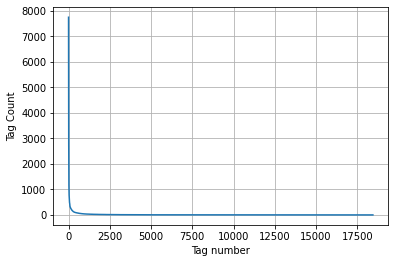

In [25]:
#Plotting the tag count
plt.plot(per_tag_counts)
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Tag Count")
plt.show()

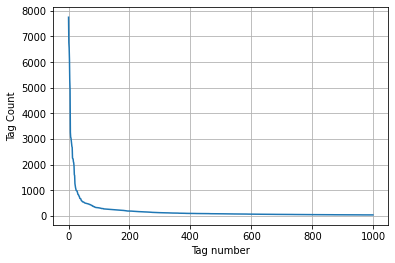

In [26]:
#Taking only the first 1000 tags with high frequency
plt.plot(per_tag_counts[0:1000])
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Tag Count")
plt.show()

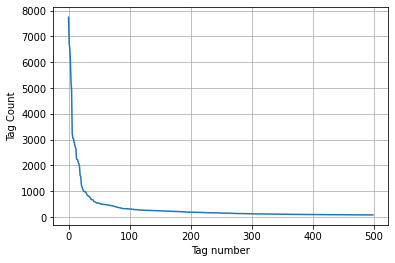

In [27]:
#Taking only the first 500 tags with high frequency
plt.plot(per_tag_counts[0:500])
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Tag Count")
plt.show()

In [28]:

tags_used_morethan_100_times = per_tag_count_data_frame[per_tag_count_data_frame.Count>100].Tags
tags_used_morethan_1000_times = per_tag_count_data_frame[per_tag_count_data_frame.Count>1000].Tags
tags_used_morethan_5000_times = per_tag_count_data_frame[per_tag_count_data_frame.Count>5000].Tags
print(f'Tags used more than 100 times is {len(tags_used_morethan_100_times)} tags')
print(f'Tags used more than 1000 times is {len(tags_used_morethan_1000_times)} tags')
print(f'Tags used more than 5000 times is {len(tags_used_morethan_5000_times)} tags')

Tags used more than 100 times is 384 tags
Tags used more than 1000 times is 25 tags
Tags used more than 5000 times is 5 tags


In [29]:
from datetime import datetime

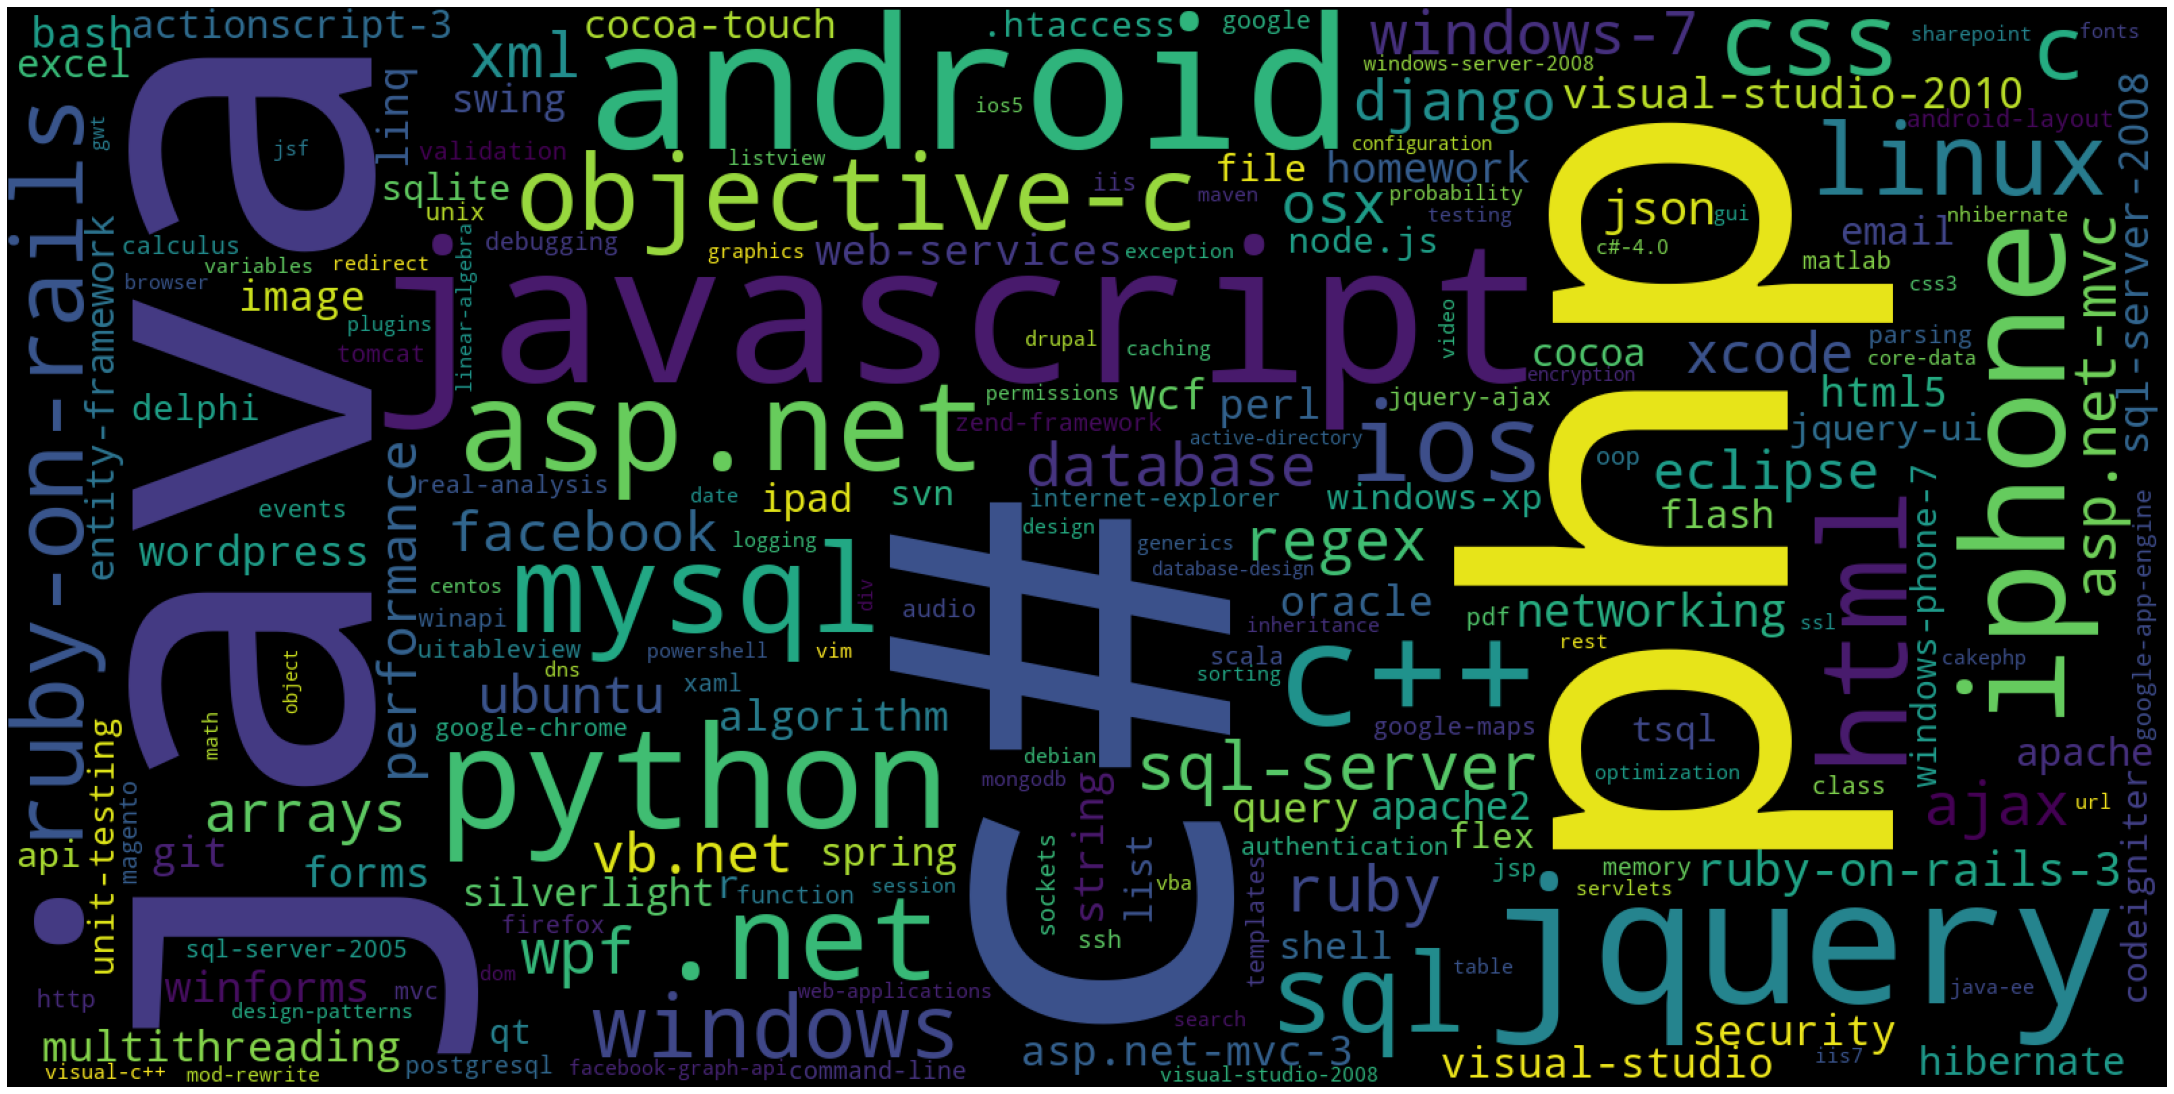

Time taken to run this cell : 0:00:05.329133


In [30]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(per_tag_count_data.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

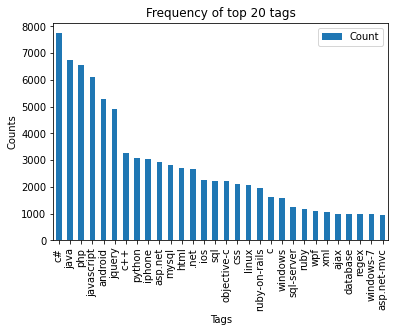

In [31]:
#Plotting the top 20 tags having highest frequency
i = np.arange(30)
per_tag_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, per_tag_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

In [32]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
qus_list=[]
qus_with_code = 0
len_before_preprocessing = 0 
len_after_preprocessing = 0 
for index,row in data1.iterrows():
    title, body, tags = row["Title"], row["Body"], row["Tags"]
    if '<code>' in body:
        qus_with_code+=1
    len_before_preprocessing+=len(title) + len(body)
    body=re.sub('<code>(.*)</code>', '', body, flags=re.MULTILINE|re.DOTALL)
    body = re.sub('<.*?>', ' ', str(body.encode('utf-8')))
    title=title.encode('utf-8')
    question=str(title)+" "+str(body)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    qus_list.append(question)
    len_after_preprocessing += len(question)
data1["question"] = qus_list
avg_len_before_preprocessing=(len_before_preprocessing*1.0)/data1.shape[0]
avg_len_after_preprocessing=(len_after_preprocessing*1.0)/data1.shape[0]
print( "Avg. length of questions(Title+Body) before preprocessing: ", avg_len_before_preprocessing)
print( "Avg. length of questions(Title+Body) after preprocessing: ", avg_len_after_preprocessing)
print ("% of questions containing code: ", (qus_with_code*100.0)/data1.shape[0])

Avg. length of questions(Title+Body) before preprocessing:  1150.2430306931092
Avg. length of questions(Title+Body) after preprocessing:  282.92985437869584
% of questions containing code:  56.070236131783254


In [33]:
#Making a connection to database
conn = sqlite3.connect('Question.db') 
c = conn.cursor()
#Creating tables
c.execute('CREATE TABLE Tag (Questions, Tags )')
conn.commit()

In [34]:
#Selecting only the tags and questions and appending it to new DataFrame
refined_data = pd.concat([data1['Tags'],data1['question']],axis=1)
#Appending dataframe to database
refined_data.to_sql('Tag', conn, if_exists='replace', index = False)

In [35]:
con = sqlite3.connect('Question.db')
sampled_questions = pd.read_sql_query('SELECT Question,Tags from Tag ORDER BY RANDOM() LIMIT 50000', con)
con.close()

In [36]:
sampled_questions.shape

(50000, 2)

#Selecting the tags and converting tags into binary form for the problem

In [37]:
cv1 = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
binary_tags = cv1.fit_transform(sampled_questions['Tags'])

In [38]:
#Unique tags
print(binary_tags.shape[1])

13939


In [39]:
def choose_tags(n):
    t = binary_tags.sum(axis=0).tolist()[0] #Adding rowwise and hence finding the count of each tag
    sorted_tags_i = sorted(range(len(t)), key=lambda i:t[i], reverse=True) #Sorting it in descending order
    binary_tags_chose=binary_tags[:,sorted_tags_i[:n]] #Selecting the tags upto n
    return binary_tags_chose

In [40]:
def uncovered_questions(n):
    binary_tags_chose = choose_tags(n) #Selecting the tags upto n
    x= binary_tags_chose.sum(axis=1) #Adding columnwise to find which tags are not covered
    return (np.count_nonzero(x==0))  #returning the count of tags which are left uncovered

In [41]:
questions_explained= [] 
total_tags=binary_tags.shape[1] #Total number of unique tags
total_qs=sampled_questions.shape[0] #Toatl questions
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-uncovered_questions(i))/total_qs)*100,3)) 

In [42]:
questions_to_select = pd.DataFrame(questions_explained,columns=['Questions Covered'])
questions_to_select['Total_Tag'] = [i for i in range(500,total_tags,100)]

In [43]:
questions_to_select

,Questions Covered,Total_Tag
0,89.546,500
1,90.798,600
2,91.778,700
3,92.754,800
4,93.362,900
...,...,...
130,99.980,13500
131,99.986,13600
132,99.990,13700
133,99.996,13800


In [44]:
#Tags which cover upto 99% of questions
questions_to_select[questions_to_select['Questions Covered'] > 99]

,Questions Covered,Total_Tag
42,99.004,4700
43,99.022,4800
44,99.056,4900
45,99.086,5000
46,99.112,5100
...,...,...
130,99.980,13500
131,99.986,13600
132,99.990,13700
133,99.996,13800


In [45]:
sampled_questions.head(10)

,question,Tags
0,get record date date access databas tabl call ...,c# sql winforms ms-access
1,semi structur data model appropri structur one...,xml database relational-database non-relationa...
2,imodelbind asp net mvc beta anyon link tutori ...,asp.net-mvc beta imodelbinder
3,eleg way find prime number specifi rang possib...,r primes number-theory
4,make galleri imag text android wan na make gal...,android android-layout android-gallery
5,addit group apach user configur user group apa...,linux apache2 groups user-permissions
6,make hibern includ field join tabl select clau...,hibernate
7,wordpress templat redirect work php wp footer ...,javascript jquery wordpress action hook
8,fill display button entir height problem diffe...,android android-layout
9,transpar webview work android background quest...,android android-webview


In [46]:
sampled_tag = choose_tags(4700) #Choosing 4200 tags since it covers almost 99 % of questions
print("number of questions that are not covered :", uncovered_questions(4700),"out of ", total_qs)

number of questions that are not covered : 498 out of  50000


In [47]:
#Taking 80 % of data as training data and 20 % as testing data
total_size=sampled_questions.shape[0] 
train_size=int(0.80*total_size)  
X_train=sampled_questions.head(train_size)
X_test=sampled_questions.tail(total_size - train_size)
y_train = sampled_tag[0:train_size,:]
y_test = sampled_tag[train_size:total_size,:]

In [48]:
start = datetime.now()
#Using Tfidf Vectoriser for transformation
tfv = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2",tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
X_train_transformed = tfv.fit_transform(X_train['question'])
X_test_transformed = tfv.transform(X_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:17.837092


#Training the Model

In [49]:
%%time
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(X_train_transformed, y_train)
predictions = classifier.predict(X_test_transformed)

print("accuracy :",accuracy_score(y_test,predictions))
print("macro f1 score :",f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",hamming_loss(y_test,predictions))
print("Precision recall report :\n",classification_report(y_test, predictions))

accuracy : 0.0749
macro f1 score : 0.08308318797384766
micro f1 scoore : 0.36435600021988895
hamming loss : 0.0004920425531914894
Precision recall report :
               precision    recall  f1-score   support

           0       0.55      0.25      0.34       786
           1       0.76      0.43      0.55       733
           2       0.80      0.56      0.66       631
           3       0.77      0.41      0.53       649
           4       0.91      0.72      0.81       550
           5       0.85      0.65      0.74       494
           6       0.69      0.31      0.43       312
           7       0.70      0.42      0.53       307
           8       0.80      0.63      0.71       254
           9       0.69      0.41      0.51       323
          10       0.84      0.61      0.71       267
          11       0.40      0.15      0.21       268
          12       0.42      0.10      0.16       282
          13       0.59      0.28      0.38       254
          14       0.52      0.2

#Hyperparameter Tuning

In [ ]:
%%time
import sklearn
from sklearn.model_selection import RandomizedSearchCV
model =  OneVsRestClassifier(SGDClassifier(loss='log',penalty='l1'))

param_grid  = {"estimator__alpha": [10**-5,10**-3, 10**-1,10**1,10**2]}
rsc = RandomizedSearchCV(model,param_grid,scoring='f1_micro',cv =5 )
rsc.fit(X_train_transformed,y_train)

CPU times: user 4h 37min 1s, sys: 2h 58min 57s, total: 7h 35min 59s
Wall time: 4h 23min 20s
